In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

df = pd.read_csv('HR.csv')
df.head(5)

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


Рассчитаем основные статистики для переменных

In [2]:
df.describe(include = 'all')

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,department,salary
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999,14999
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,3
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sales,low
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4140,7316
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268,NaN,NaN
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281,NaN,NaN
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000,NaN,NaN
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000,NaN,NaN
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000,NaN,NaN
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000,NaN,NaN


In [3]:
df.mode()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,department,salary
0,0.1,0.55,4.0,135,3.0,0.0,0.0,0.0,sales,low
1,NaN,NaN,NaN,156,NaN,NaN,NaN,NaN,NaN,NaN


Проверим распределение по категориям для качественных данных

In [4]:
df.groupby(['Work_accident'], as_index=False).size()

,Work_accident,size
0,0,12830
1,1,2169


In [5]:
df.groupby(['left'], as_index=False).size()

,left,size
0,0,11428
1,1,3571


In [6]:
df.groupby(['promotion_last_5years'], as_index=False).size()

,promotion_last_5years,size
0,0,14680
1,1,319


In [7]:
df.groupby(['department'], as_index=False).size()

,department,size
0,IT,1227
1,RandD,787
2,accounting,767
3,hr,739
4,management,630
5,marketing,858
6,product_mng,902
7,sales,4140
8,support,2229
9,technical,2720


In [8]:
df.groupby(['salary'], as_index=False).size()

,salary,size
0,high,1237
1,low,7316
2,medium,6446


Рассмотрим корреляционную матрицу

Text(0.5, 1.0, 'HR')

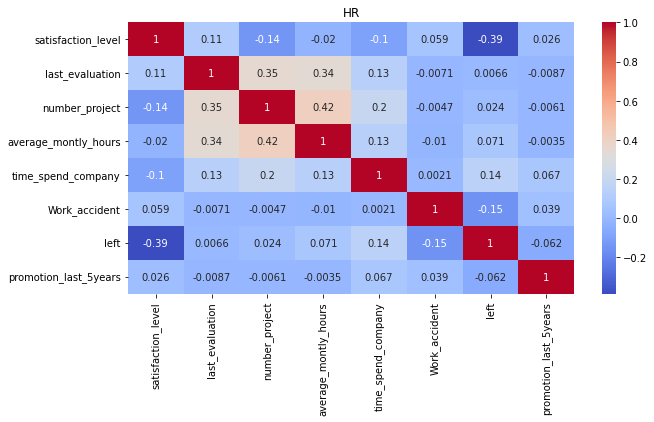

In [9]:
fig, ax = plt.subplots(figsize = (10, 5))
rcParams['font.size'] = 10
heatmap = sns.heatmap(df.corr(), annot = True, cmap = 'coolwarm')
heatmap.set_title('HR')

Корреляционная матрица для количественных признаков

Text(0.5, 1.0, 'HR')

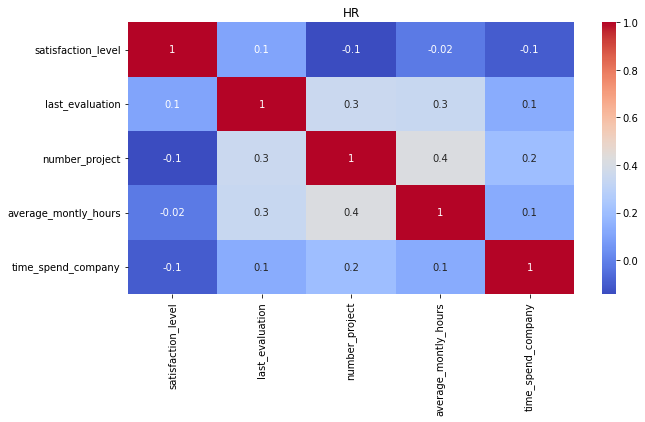

In [10]:
df_count = df[['satisfaction_level', 'last_evaluation', 'number_project', 'average_montly_hours', 'time_spend_company']]
fig, ax = plt.subplots(figsize = (10, 5))
rcParams['font.size'] = 10
heatmap = sns.heatmap(df_count.corr(), annot = True, fmt = '.1g', cmap = 'coolwarm')
heatmap.set_title('HR')

Из визуализации heatmap можно увидеть, что average_montly_hours и number_project - наиболее скоррелированные признаки. Отсюда можно сделать вывод о том, что количество проектов, выполненных за время работы, напрямую связано с количеством часов, проведенных на рабочем месте. Наименее скоррелированные признаки - это average_montly_hours и satisfaction_level, что говорит об их очень низкой связи.

Рассчитаем общее количество сотрудников (включая уволенных), а также количество действующих сотрудников в каждом департаменте

In [11]:
df0 = df[df['left'] == 0].groupby(['department'], as_index = False).size()
df0 = pd.concat([df0, pd.DataFrame({'department': ['Sum'], 'size': [df0['size'].sum()]})], ignore_index = True)
df1 = df.groupby(['department'], as_index = False).size()
df1 = pd.concat([df1, pd.DataFrame({'department': ['Sum'], 'size': [df1['size'].sum()]})], ignore_index = True)
df1['Current'] = df0['size'].tolist()
df1.columns = ['Department', 'Total Number', 'Current Number']
df1.set_index('Department')

,Total Number,Current Number
Department,,
IT,1227,954
RandD,787,666
accounting,767,563
hr,739,524
management,630,539
marketing,858,655
product_mng,902,704
sales,4140,3126
support,2229,1674


Рассчитаем распределение сотрудников по зарплате

<Axes: xlabel='Salary'>

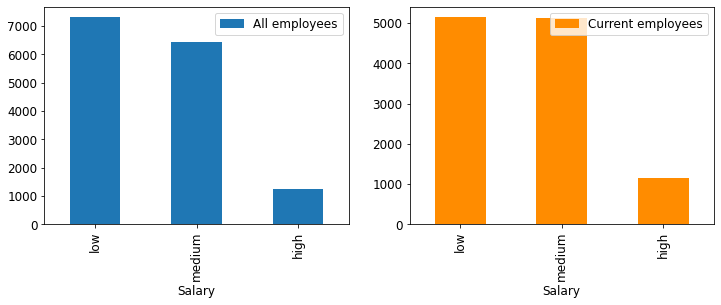

In [12]:
rcParams['font.size'] = 12
df_salary = df.groupby(['salary'], as_index = False).size().sort_values(by = 'size', ascending = False)
df_salary['Current'] = df[df['left'] == 0].groupby(['salary'], as_index = False).size().sort_values(by = 'size', ascending = False)['size'].tolist()
df_salary.columns = ['Salary', 'All employees', 'Current employees']
fig, axes = plt.subplots(1, 2, figsize = (12, 4))
df_salary[['Salary', 'All employees']].plot(ax = axes[0], x = 'Salary', kind = 'bar')
df_salary[['Salary', 'Current employees']].plot(ax = axes[1], x = 'Salary', kind = 'bar', color = 'darkorange')

Рассчитаем распределение сотрудников по зарплате в каждом департаменте

<Axes: title={'center': 'Salary for current employees'}, xlabel='department'>

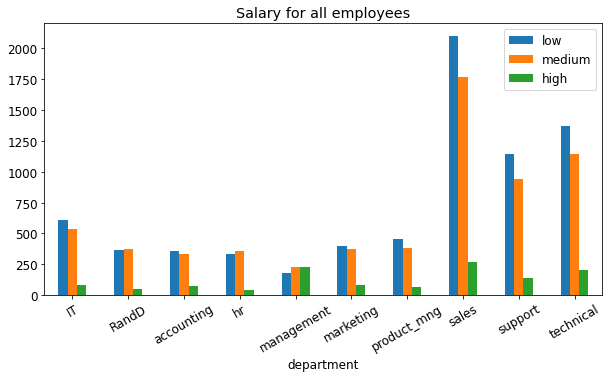

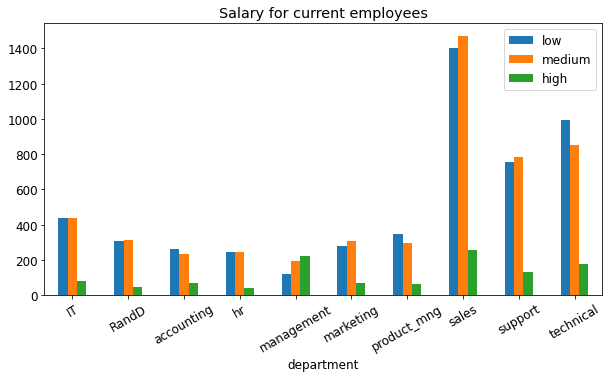

In [13]:
deps = df.groupby(['department', 'salary']).size().reset_index()
deps_new = deps[deps['salary'] == 'low'].set_index('department').merge(deps[deps['salary'] == 'medium'].set_index('department'), on = 'department', how = 'left').merge(deps[deps['salary'] == 'high'].set_index('department'), on = 'department', how = 'left')
deps_new.rename(columns = {'0_x': 'low', '0_y': 'medium', 0: 'high'}, inplace = True)
deps_new.filter(['department', 'low', 'medium', 'high']).plot.bar(title = 'Salary for all employees', figsize=(10, 5), rot = 30)
deps = df[df['left'] == 0].groupby(['department', 'salary']).size().reset_index()
deps_new = deps[deps['salary'] == 'low'].set_index('department').merge(deps[deps['salary'] == 'medium'].set_index('department'), on = 'department', how = 'left').merge(deps[deps['salary'] == 'high'].set_index('department'), on = 'department', how = 'left')
deps_new.rename(columns = {'0_x': 'low', '0_y': 'medium', 0: 'high'}, inplace = True)
deps_new.filter(['department', 'low', 'medium', 'high']).plot.bar(title = 'Salary for current employees', figsize=(10, 5), rot = 30)

Как мы можем видеть из визуализации, для менеджмента свойственна большая доля сотрудников с высокой зарплатой. Для других департаментов характерны преимущественно низкие и средние зарплаты.

Проверим гипотезу о том, что сотрудники с высоким окладом проводят на работе больше времени, чем сотрудники с низким окладом

Гипотезы

H0: Средние выборок одинаковы

H1: Средние выборок различаются

In [14]:
df_time = df[['salary', 'average_montly_hours']]
stat, p = stats.ttest_ind(df_time[df_time['salary'] == 'low']['average_montly_hours'], df_time[df_time['salary'] == 'high']['average_montly_hours'])

print(f"Статистика = {stat:.3f}, p = {p:.5f}")

if p < 0.05:
  print('Отклоняем нулевую гипотезу')
else:
  print('Не отклоняем нулевую гипотезу')

Статистика = 0.729, p = 0.46610
Не отклоняем нулевую гипотезу


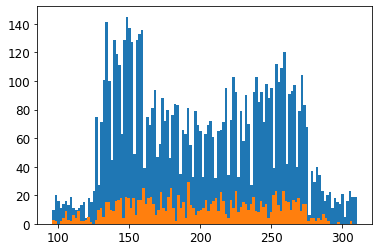

In [15]:
plt.hist(df_time[df_time['salary'] == 'low']['average_montly_hours'], bins = 120);
plt.hist(df_time[df_time['salary'] == 'high']['average_montly_hours'], bins = 120);

In [16]:
stat, p = stats.mannwhitneyu(df_time[df_time['salary'] == 'low']['average_montly_hours'], df_time[df_time['salary'] == 'high']['average_montly_hours'])

print(f"Статистика = {stat:.5f}, p = {p:.5f}")

if p < 0.05:
  print('Отклоняем нулевую гипотезу, распределения, вероятно, различаются')
else:
  print('Не отклоняем нулевую гипотезу, распределения, вероятно, одинаковые')

Статистика = 4542795.50000, p = 0.82413
Не отклоняем нулевую гипотезу, распределения, вероятно, одинаковые


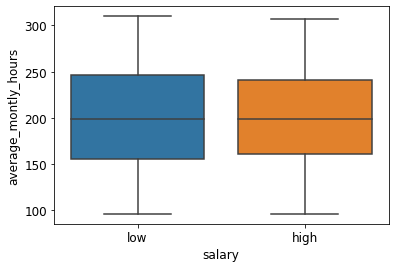

In [17]:
ax = sns.boxplot(x = 'salary', y = 'average_montly_hours', data = df_time[df_time['salary'].isin(['low', 'high'])])
plt.show()

In [18]:
fvalue, p = stats.f_oneway(df_time[df_time['salary'] == 'low']['average_montly_hours'], df_time[df_time['salary'] == 'medium']['average_montly_hours'], df_time[df_time['salary'] == 'high']['average_montly_hours'])

print(f"Статистика = {stat:.3f}, p = {p:.6f}")

if p < 0.05:
  print('Отклоняем нулевую гипотезу')
else:
  print('Не отклоняем нулевую гипотезу')

Статистика = 4542795.500, p = 0.632327
Не отклоняем нулевую гипотезу


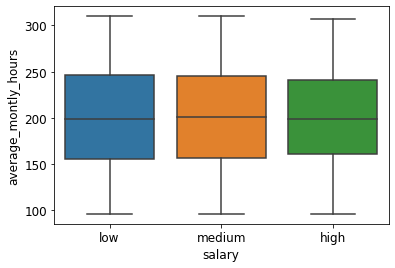

In [19]:
ax = sns.boxplot(x = 'salary', y = 'average_montly_hours', data = df_time)
plt.show()

На основе проведенного анализа можно сделать вывод, что гипотеза о том, что сотрудники с высоким окладом проводят на работе больше времени, чем сотрудники с низким окладом, неверна. Количество часов на рабочем месте в месяц для сотрудников в зависимости от оклада распределено одинаково.

Рассчитаем показатели среди уволившихся и не уволившихся сотрудников

In [20]:
df_left = df[df['left'] == 1]
df_current = df[df['left'] == 0]
print('Доля сотрудников с повышением за последние 5 лет:')
print(f"Среди уволившихся - {df_left['promotion_last_5years'].sum()/len(df_left):.4f}")
print(f"Среди текущих сотрудников - {df_current['promotion_last_5years'].sum()/len(df_current):.4f}")

Доля сотрудников с повышением за последние 5 лет:
Среди уволившихся - 0.0053
Среди текущих сотрудников - 0.0263


In [21]:
print('Средняя степень удовлетворенности:')
print(f"Среди уволившихся - {df_left['satisfaction_level'].mean():.4f}")
print(f"Среди текущих сотрудников - {df_current['satisfaction_level'].mean():.4f}")

Средняя степень удовлетворенности:
Среди уволившихся - 0.4401
Среди текущих сотрудников - 0.6668


In [22]:
print('Среднее количество проектов:')
print(f"Среди уволившихся - {df_left['number_project'].mean():.3f}")
print(f"Среди текущих сотрудников - {df_current['number_project'].mean():.3f}")

Среднее количество проектов:
Среди уволившихся - 3.856
Среди текущих сотрудников - 3.787


Как мы можем видеть, среднее количество проектов у уволившихся и действующих сотрудников практически не отличается. В то же время степень удовлетворенности для действующих сотрудников выше, как и доля сотрудников с повышением за 5 лет.

Построим модель LDA (линейный дискриминантный анализ), предсказывающую уволился ли сотрудник на основе имеющихся факторов

In [23]:
x = df.drop(columns = ['department', 'salary', 'left'])
y = df['left'].tolist()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 42)
lda = LinearDiscriminantAnalysis()
lda.fit(x_train, y_train)
y_pred = lda.predict(x_test)
print(f'Точность прогноза: {accuracy_score(y_test, lda.predict(x_test)):.4f}')

Точность прогноза: 0.7558


Матрица ошибок

In [24]:
confusion_matrix(y_test, y_pred)

array([[3138,  290],
       [ 809,  263]])

In [25]:
res = x_test.copy()
res['Predict'] = y_pred
res['Fact'] = y_test
res[res['Fact'] == 1].head(10)

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,Predict,Fact
862,0.41,0.47,2,154,3,0,0,0,1
542,0.77,0.91,5,236,5,0,0,0,1
12070,0.74,0.99,2,277,3,0,0,0,1
14768,0.43,0.57,2,157,3,0,0,0,1
1889,0.11,0.95,6,279,4,0,0,1,1
169,0.45,0.57,2,158,3,0,0,0,1
1795,0.85,0.96,4,217,5,0,0,0,1
14303,0.42,0.48,2,143,3,0,0,0,1
1039,0.82,1.00,4,273,6,0,0,0,1
12036,0.38,0.46,2,137,3,0,0,0,1


Как мы можем заметить, модель LDA недостаточно точно предсказывает увольнение сотрудника на основе имеющихся признаков.

Попробуем уменьшить количество признаков, основываясь на матрице корреляций

In [26]:
x = df.drop(columns = ['department', 'salary', 'left', 'last_evaluation', 'number_project', 'promotion_last_5years'])
y = df['left'].tolist()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 42)
lda = LinearDiscriminantAnalysis()
lda.fit(x_train, y_train)
y_pred = lda.predict(x_test)
print(f'Точность прогноза: {accuracy_score(y_test, lda.predict(x_test)):.4f}')

Точность прогноза: 0.7573


In [27]:
confusion_matrix(y_test, y_pred)

array([[3132,  296],
       [ 796,  276]])

Модель на основе двух признаков

In [28]:
x = df.drop(columns = ['department', 'salary', 'left', 'last_evaluation', 'number_project', 'promotion_last_5years', 'average_montly_hours', 'time_spend_company'])
y = df['left'].tolist()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 42)
lda = LinearDiscriminantAnalysis()
lda.fit(x_train, y_train)
y_pred = lda.predict(x_test)
print(f'Точность прогноза: {accuracy_score(y_test, lda.predict(x_test)):.4f}')

Точность прогноза: 0.7611


In [29]:
confusion_matrix(y_test, y_pred)

array([[3164,  264],
       [ 811,  261]])

Чтобы улучшить предсказание увольнения сотрудника, попробуем уменьшить значение ошибки 2-го рода, подбирая параметры с помощью GridSearchCV

In [30]:
x = df.drop(columns = ['department', 'salary', 'left'])
y = df['left'].tolist()

lda = LinearDiscriminantAnalysis()
parametrs = {'solver': ['lsqr', 'eigen'], 'shrinkage': np.arange(0.0, 1.0, 0.01)}
grid = GridSearchCV(lda, parametrs, cv = 5, scoring = 'recall')
grid.fit(x, y)
grid.best_params_

{'shrinkage': 0.99, 'solver': 'lsqr'}

In [31]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 42)
lda = LinearDiscriminantAnalysis(solver = 'lsqr', shrinkage = 0.99)
lda.fit(x_train, y_train)
y_pred = lda.predict(x_test)
print(f'Точность прогноза: {accuracy_score(y_test, lda.predict(x_test)):.4f}')

Точность прогноза: 0.7160


In [32]:
confusion_matrix(y_test, y_pred)

array([[2382,  471],
       [ 594,  303]])

Как мы можем видеть, подобранные параметры позволили снизить вероятность ошибки второго рода, однако в то же время снизилось и значение точности прогноза.

Попробуем перевести признак salary в численное значение и использовать его для построения модели

In [39]:
df_ = df.copy()
dict1 = {'low': 1, 'medium': 2, 'high': 3}
df_['salary'] = df_['salary'].map(dict1)
df_.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,1
1,0.80,0.86,5,262,6,0,1,0,sales,2
2,0.11,0.88,7,272,4,0,1,0,sales,2
3,0.72,0.87,5,223,5,0,1,0,sales,1
4,0.37,0.52,2,159,3,0,1,0,sales,1


Text(0.5, 1.0, 'HR')

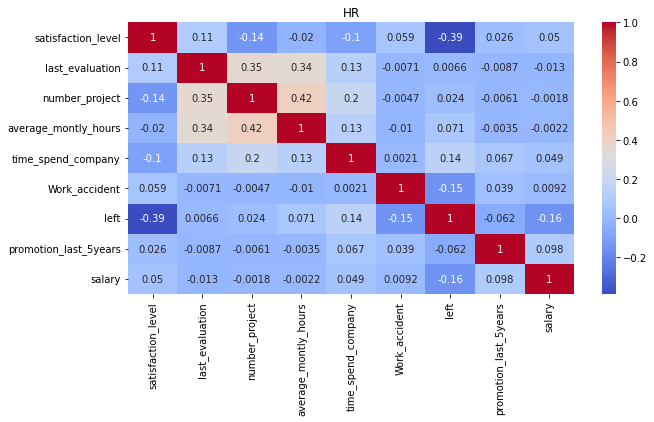

In [40]:
fig, ax = plt.subplots(figsize = (10, 5))
rcParams['font.size'] = 10
heatmap = sns.heatmap(df_.corr(), annot = True, cmap = 'coolwarm')
heatmap.set_title('HR')

Признак salary является вторым по значению корреляции с признаком left после satisfaction_level.

In [72]:
x = df_.drop(columns = ['department', 'left'])
y = df_['left'].tolist()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 42)
lda = LinearDiscriminantAnalysis()
lda.fit(x_train, y_train)
y_pred = lda.predict(x_test)
print(f'Точность прогноза: {accuracy_score(y_test, lda.predict(x_test)):.4f}')

Точность прогноза: 0.7700


In [73]:
confusion_matrix(y_test, y_pred)

array([[3152,  276],
       [ 759,  313]])

Модель на основе двух признаков

In [74]:
x = df_.drop(columns = ['department', 'left', 'last_evaluation', 'number_project', 'promotion_last_5years', 'average_montly_hours', 'time_spend_company'])
y = df_['left'].tolist()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 42)
lda = LinearDiscriminantAnalysis()
lda.fit(x_train, y_train)
y_pred = lda.predict(x_test)
print(f'Точность прогноза: {accuracy_score(y_test, lda.predict(x_test)):.4f}')

Точность прогноза: 0.7900


In [75]:
confusion_matrix(y_test, y_pred)

array([[3178,  250],
       [ 695,  377]])

Как мы можем заметить, добавление признака salary для построения модели позволило несколько улучшить точность прогноза по сравнению с первоначальной моделью.